# <h1 align='center'> A Comparison of Covid-19 Time Series Models Forecasting Cases, Hospitalizations, and Deaths for New York
<h1 align='center'>Appendix D - AR, MA, ARMA, ARIMA, and SARIMA models</h1>

<ul align='center'>
    <li>Santosh Cheruku</li>
     <li>Angel Claudio</li>
     <li>John K. Hancock</li>
     <li>John Suh</li>
     <li>Subhalaxmi Rout</li>
</ul>


# Setup

## Libraries

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.ar_model import AR
import statsmodels.api as sm
import itertools

warnings.filterwarnings('ignore')


## Declarations

In [220]:
# Function for Dicky Fuller Test
def dicky_fuller_test(dataset, feature):

    data = dataset[feature]

    # Print Out Heading for Test
    print('Results of Dickey-Fuller Test for:', feature)

    # Set test arguments and run
    test_results = adfuller(data, autolag='AIC')

    # Extract test results
    print("1. ADF: ", test_results[0])
    print("p-value: ", test_results[1])
    print("No. of lags: ", test_results[2])
    print("No. of observation used for ADF regression and critical value calculation: ", test_results[3])
    print("Critical Value: " )

    # Loop through Critical Values (inside 4) to display and print results
    for k,v in test_results[4].items():
        print("\t", k, " : ", v)

    if test_results[1] < .05:
        print("The p-value is significant at ", test_results[1],
              ", meaning we can reject the null hypothesis in favor that the data is stationary.")
    else:
        print("The p-value is too large at ", test_results[1],
              ", meaning we cannot reject the null hypothesis and assume the data is non-stationary.")

    # show a plot of the data


## Data Import

In [221]:
df2 = pd.read_csv('https://raw.githubusercontent.com/JohnKHancock/CUNY_DATA_698_Maters_Project/main/raw_data/final-ny-data-v2.csv'
                  , parse_dates = ['date'])
# check import is good
# df2.info
# df2.dtypes

# set feature interested in, in one place
lst_of_features = ['positive', 'death', 'hospitalized']
feature_interested_in = 'positive'

## Set Up Data (Positive Cases, Hospitalized, and Deaths)

In [222]:
# Set up dataframes with date index
df_positive_cases = pd.DataFrame(df2, columns = ['date', 'positive'])
df_hospitalized = pd.DataFrame(df2, columns = ['date', 'hospitalized'])
df_deaths = pd.DataFrame(df2, columns = ['date', 'death'])

df_positive_cases.set_index('date', inplace = True)
df_hospitalized.set_index('date', inplace = True)
df_deaths.set_index('date', inplace = True)

# Model Approach

We are planning to working on 

* Auto Regressive model(AR)
* Moving Average model(MA)
* Autoregressive and moving average model(ARMA) 
* Autoregressive Integrated Moving Average model(ARIMA)
* Seasonal Autoregressive Integrated Moving Average model(SARIMA)

The model is intended to better understand the trajectory of future forecasts related to any particular time series.


## Stationary Data Check

For data to be stationary, the statistical properties of a system do not change over time, this means mean,
variance and co-various should be same over period of time.

# Dicky Fuller Test

Below we will use the Dicky Fuller Test to assess if the data set we have is stationary or non-stationary.


## Test on Positive Cases

Results of Dickey-Fuller Test for: positive
1. ADF:  -3.1895164270403504
p-value:  0.020599585879087043
No. of lags:  8
No. of observation used for ADF regression and critical value calculation:  112
Critical Value: 
	 1%  :  -3.4901313156261384
	 5%  :  -2.8877122815688776
	 10%  :  -2.5807296460459184
The p-value is significant at  0.020599585879087043 , meaning we can reject the null hypothesis in favor that the data is stationary.


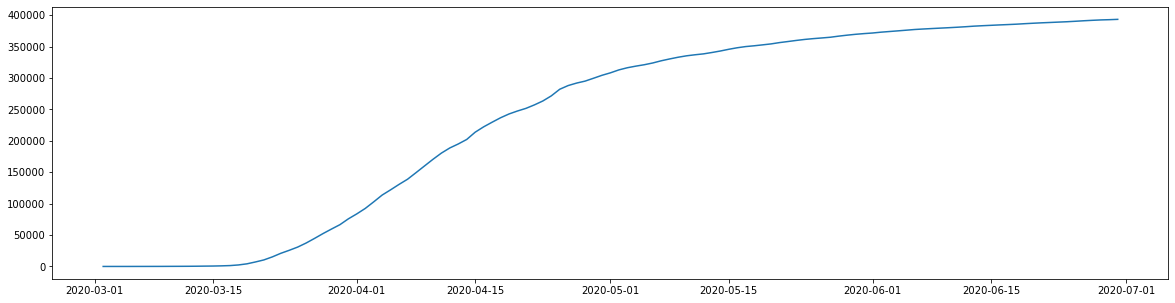

In [223]:
dicky_fuller_test(df_positive_cases, 'positive')
plt.plot(df_positive_cases)
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

## Test on Hospitalized

Results of Dickey-Fuller Test for: hospitalized
1. ADF:  -2.59845653813736
p-value:  0.09331668941023946
No. of lags:  9
No. of observation used for ADF regression and critical value calculation:  111
Critical Value: 
	 1%  :  -3.490683082754047
	 5%  :  -2.8879516565798817
	 10%  :  -2.5808574442009578
The p-value is too large at  0.09331668941023946 , meaning we cannot reject the null hypothesis and assume the data is non-stationary.


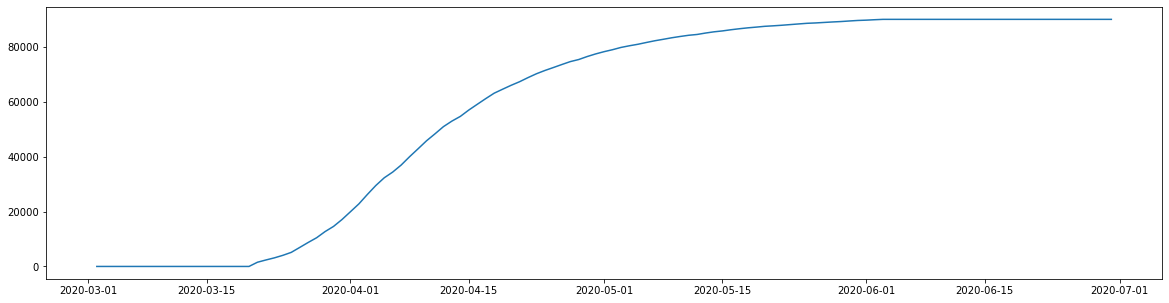

In [224]:
dicky_fuller_test(df_hospitalized, 'hospitalized')
plt.plot(df_hospitalized)
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

## Test on Deaths

Results of Dickey-Fuller Test for: death
1. ADF:  -2.3552340309285453
p-value:  0.15477177519907637
No. of lags:  3
No. of observation used for ADF regression and critical value calculation:  117
Critical Value: 
	 1%  :  -3.487517288664615
	 5%  :  -2.8865777180380032
	 10%  :  -2.5801239192052012
The p-value is too large at  0.15477177519907637 , meaning we cannot reject the null hypothesis and assume the data is non-stationary.


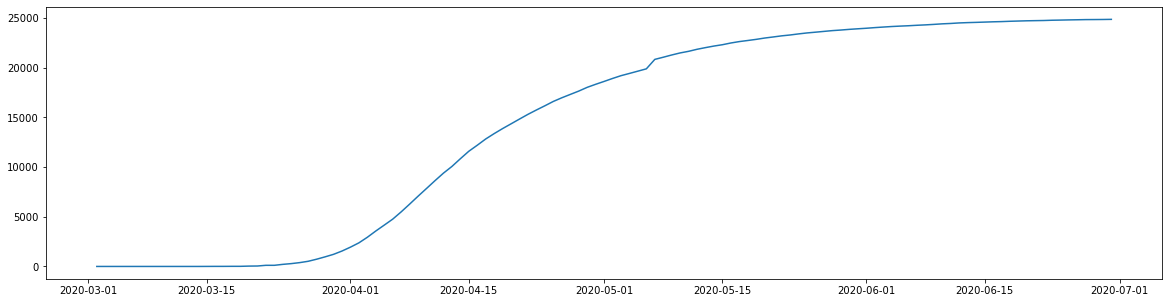

In [225]:
dicky_fuller_test(df_deaths, 'death')
plt.plot(df_deaths)
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

## Summary of the Dicky Fuller Tests

We can see from the above that the data for positive is considered stationary, while hospitalized and deaths were
evaluated to be non-stationary data. Therefore, we will have to apply lag in order to transform the
non-stationary data to stationary.

## AR Model

Auto Regressive Model : An autoregressive (AR) model predicts future behavior based on past behavior.

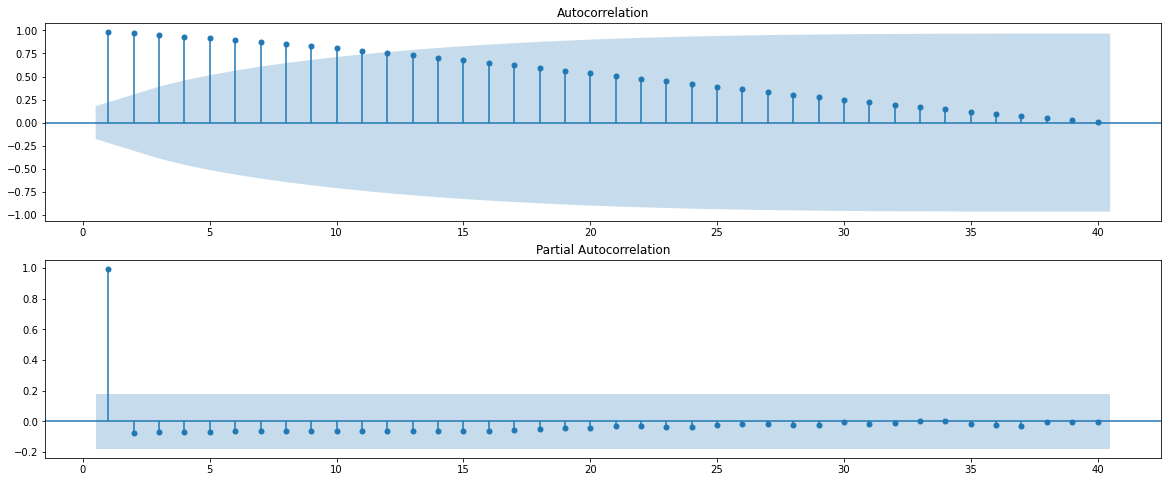

In [226]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_positive_cases['positive'].iloc[:],lags=40,ax=ax1, zero = False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_positive_cases['positive'].iloc[:],lags=40,ax=ax2, zero = False)

As you can see, after lag 2, the PACF coefficients are not significant anymore. Therefore, we will assume an autoregressive process of order 2.
Split data in to train and test, fit model and calculate forecast. 

(106, 1) (15, 1)
                              ARMA Model Results                              
Dep. Variable:               positive   No. Observations:                  106
Model:                     ARMA(2, 0)   Log Likelihood                -895.640
Method:                       css-mle   S.D. of innovations           1063.936
Date:                Fri, 16 Apr 2021   AIC                           1799.280
Time:                        08:46:42   BIC                           1809.934
Sample:                    03-02-2020   HQIC                          1803.598
                         - 06-15-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.175e+05   9.08e+04      2.397      0.017    3.96e+04    3.95e+05
ar.L1.positive     1.9727      0.017    115.525      0.000       1.939       2.006
ar.L2.positive    -

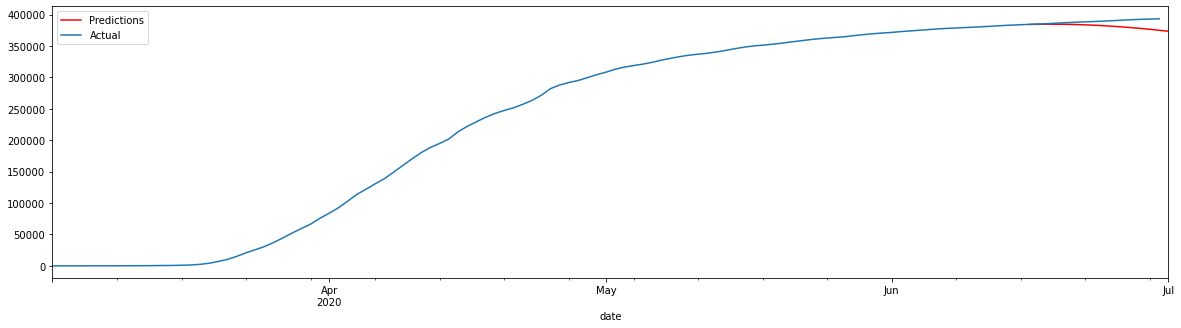

In [227]:
# divide data between training and test
train_ar = df_positive_cases.iloc[:-15]
test_ar = df_positive_cases.iloc[-15:]
print(train_ar.shape, test_ar.shape)
model_ar_positive = ARMA(train_ar, order=(2,0))
model_ar_positive_fit = model_ar_positive.fit()
print(model_ar_positive_fit.summary())

start_ar = len(train_ar)
end_ar = len(train_ar) + len(test_ar)
predict_ar_positive = model_ar_positive_fit.predict(start = start_ar, end = end_ar)
predict_ar_positive.plot(color = 'red')
df_positive_cases['positive'].plot()

plt.legend(['Predictions', 'Actual'], loc='best')

Accuracy Metrics for Time Series Forecast

The commonly used accuracy metrics to judge forecasts are:

* Mean Absolute Percentage Error (MAPE)
* Mean Error (ME)
* Mean Absolute Error (MAE)
* Mean Percentage Error (MPE)
* Root Mean Squared Error (RMSE)

Mean Absolute Percentage Error (MAPE) is a statistical measure to define the accuracy of a machine learning algorithm on a particular dataset. Using MAPE, we can estimate the accuracy in terms of the differences in the actual v/s estimated values.

The Mean Error (ME)  is an informal term that usually refers to the average of all the errors in a set.

The Mean Absolute Error (MAE) is calculated as the average of the forecast error values, where all of the forecast error values are forced to be positive.

Mean Percentage Error (MPE) is the computed average of percentage errors by which forecasts of a model differ from actual values of the quantity being forecast.

Root Mean Squared Error (RMSE) is a method of measuring the difference between values predicted by a model and their actual values.

In [228]:
def forecast_accuracy(forecast, actual):
    MAPE = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    ME = np.mean(forecast - actual)             # ME
    MAE = np.mean(np.abs(forecast - actual))    # MAE
    MPE = np.mean((forecast - actual)/actual)   # MPE
    RMSE = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'MAPE':MAPE, 'ME':ME, 'MAE': MAE, 
            'MPE': MPE, 'RMSE':RMSE,
            })

fa = forecast_accuracy(predict_ar_positive, test_ar['positive'])

print("{:<15} {:<10}".format('Matrices','Values'))
for k, v in fa.items():
    print("{:<15} {:<10}".format(k, v))

Matrices        Values    
MAPE            0.018632787420463703
ME              -7291.381754797356
MAE             7291.381754797356
MPE             -0.018632787420463703
RMSE            9329.592789722843


## AR Conclusion

This model shows promising result. We will apply prediction on other model such as MA, ARIMA. If we get accuracy better than AR, then we will consider more accuracy model is our best fitted model. 

The above model, we get the equation : $y_t$ = 2.175e+05 + 1.9727$y_{t-1}$ - 0.9736$y_{t-2}$


## MA Model

Moving Average Model : the moving average(MA) model does not uses the past forecasts to predict the future values whereas it uses the errors from the past forecasts.


For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
From ACF plot we will assume moving average process of order 1.

(106, 1) (15, 1)
                              ARMA Model Results                              
Dep. Variable:               positive   No. Observations:                  106
Model:                     ARMA(0, 1)   Log Likelihood               -1341.188
Method:                       css-mle   S.D. of innovations          73997.455
Date:                Fri, 16 Apr 2021   AIC                           2688.375
Time:                        08:46:42   BIC                           2696.366
Sample:                    03-02-2020   HQIC                          2691.614
                         - 06-15-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.175e+05   1.43e+04     15.203      0.000    1.89e+05    2.46e+05
ma.L1.positive     0.9999      0.023     43.036      0.000       0.954       1.045
                   

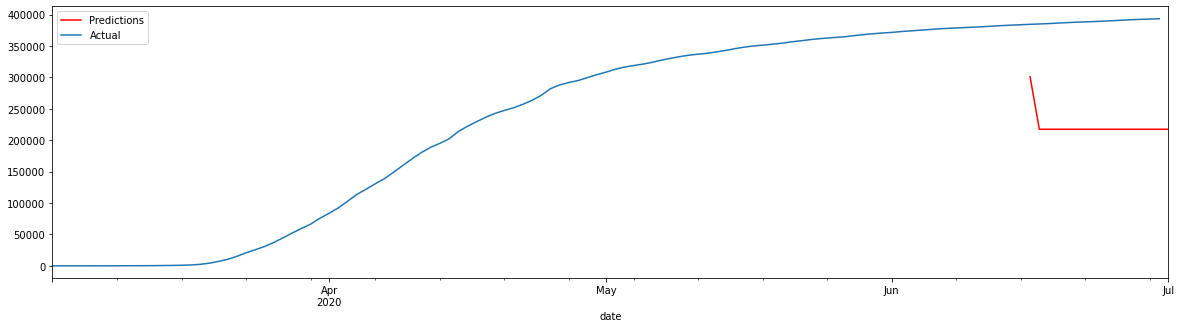

In [229]:
# divide data between training and test
train_ma = df_positive_cases.iloc[:-15]
test_ma = df_positive_cases.iloc[-15:]
print(train_ma.shape, test_ma.shape)
model_ma_positive = ARMA(train_ma, order=(0,1))
model_ma_positive_fit = model_ma_positive.fit()
print(model_ma_positive_fit.summary())

start_ma = len(train_ma)
end_ma = len(train_ma) + len(test_ma)
predict_ma_positive = model_ma_positive_fit.predict(start = start_ma, end = end_ma)
predict_ma_positive.plot(color = 'red')
df_positive_cases['positive'].plot()

plt.legend(['Predictions', 'Actual'], loc='best')

In [230]:
fa_ma = forecast_accuracy(predict_ma_positive, test_ma['positive'])

print("{:<15} {:<10}".format('Matrices','Values'))
for k, v in fa_ma.items():
    print("{:<15} {:<10}".format(k, v))

Matrices        Values    
MAPE            0.4265513028681226
ME              -166061.52581742455
MAE             166061.52581742455
MPE             -0.4265513028681226
RMSE            167536.96708900554


## MA Model Conclusion

MA model is not the best-fitted model for forecasting  of positive cases because of its high RMSE vand MAPE values.

The above model we get the equation : $y_t$ = 2.175e+05 + 0.9999$\epsilon_{t-1}$

## ARMA  

An Autoregressive Moving Average model (ARMA), is used to describe weakly stationary stochastic time series in terms of two polynomials. The first of these polynomials is for autoregression, the second for the moving average.

Often this model is referred to as the ARMA(p,q) model; where:

* p is the order of the autoregressive polynomial,
* q is the order of the moving average polynomial.

Dataset `df_positive_cases` is stationary and we did not implement and differences by using lag, so d = 0. Because d = 0, ARMA and ARIMA model will produce the same output. Let's model with ARIMA.

# ARIMA Model

ARIMA model is a statistical analysis which uses time series data.It combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the
sequence to make the sequence stationary, called integration (I).

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA
function, e.g. ARIMA(p, d, q). An ARIMA model can also be used to develop AR, MA, and ARMA models.

In Time Series Analysis ARIMA the following assumptions have to be met:

* Data has to be stationary.
* Data should be univariate.
* Data should be in time series data format.


## Model Building 

Split the data in to train and test, and apply model. We get order from ACF and PACF plot. 

### Split Data for Postive Cases

In [231]:
# make sure column is float for ARIMA model, if not error
df_positive_cases['positive'] = pd.to_numeric(df_positive_cases['positive'], downcast='float')

# verify number of observations
print('Number of obseravations: ', df_positive_cases.size)

# use range 0 to end - 30
train_arima = df_positive_cases.iloc[:-15]

# use range from end - 30 to end
test_arima = df_positive_cases.iloc[-15:]

# check to see the dimensions of the train and test data
print('Training set dimensions: ', train_arima.shape)
print('Testing set dimensions: ', test_arima.shape)

Number of obseravations:  121
Training set dimensions:  (106, 1)
Testing set dimensions:  (15, 1)


### Model Training for Positive Cases

In [232]:
# p should be 1 (AR value)
# d should be 0 if we use original data that means that we did not implement and differences by using lag
# q set to 2

model_arima_positive = ARIMA(train_arima['positive'], order=(1,0,2))
model_arima_positive_fit = model_arima_positive.fit()
model_arima_positive_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               positive   No. Observations:                  106
Model:                     ARMA(1, 2)   Log Likelihood                -958.529
Method:                       css-mle   S.D. of innovations           1933.375
Date:                Fri, 16 Apr 2021   AIC                           1927.057
Time:                        08:46:43   BIC                           1940.375
Sample:                    03-02-2020   HQIC                          1932.455
                         - 06-15-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.175e+05   1.92e+05      1.131      0.258    -1.6e+05    5.95e+05
ar.L1.positive     0.9995      0.001   1451.579      0.000       0.998       1.001
ma.L1.positive     1.2687      0.057     22.183      0.000       1.157       1.381
ma.L2.positive     0.8136      0.059     13.902      0.000       0.699       0.928
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0005           +0.0000j            1.0005            0.0000
MA.1           -0.7797           -0.7881j            1.1086           -0.3741
MA.2           -0.7797           +0.7881j            1.1086            0.3741
-----------------------------------------------------------------------------
"""

### Predict Model 

Predict the model using test data, and calculate accuracy measures.


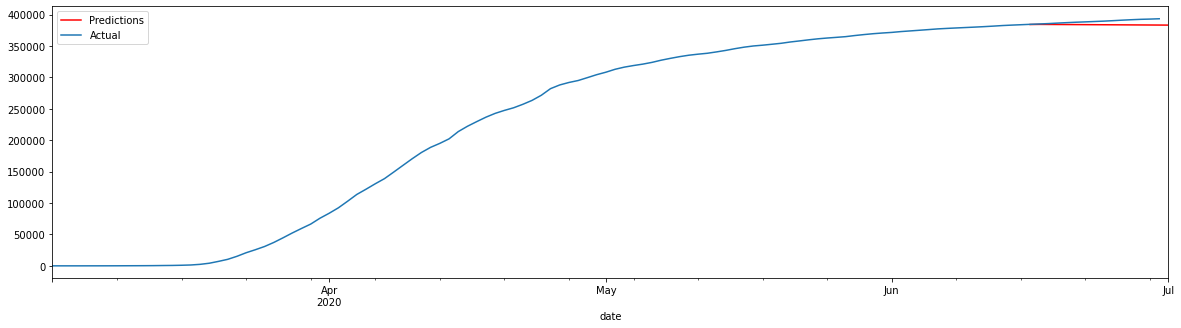

In [233]:
start_arima = len(train_arima)
end_arima = len(train_arima) + len(test_arima)
predict_arima_positive = model_arima_positive_fit.predict(start = start_arima, end = end_arima)
predict_arima_positive.plot(color = 'red')
df_positive_cases['positive'].plot()
plt.legend(['Predictions', 'Actual'], loc='best')

## Model Accuracy

Check accuracy metrices of time serise ARIMA model for postive covid cases.

In [234]:
fa_arima_positive = forecast_accuracy(predict_arima_positive, test_arima['positive'])

print("{:<15} {:<10}".format('Matrices','Values'))
for k, v in fa_arima_positive.items():
    print("{:<15} {:<10}".format(k, v))

Matrices        Values    
MAPE            0.013209238012813353
ME              -5162.513457064059
MAE             5162.513457064059
MPE             -0.013209238012813353
RMSE            6039.018610732801


## ARIMA Conclusion

This model shows promising result. This model is best fitted model for `df_positive_cases` due to small RMSE and MAPE.

The above model, we get the equation : $y_t$ = 2.175e+05 + 0.9995$y_{t-1}$ + 1.2687$\epsilon_{t-1}$ + 0.8136$\epsilon_{t-2}$


# SARIMA Model

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly
supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the
 seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

Trend Elements
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

Seasonal Elements

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

* P: Seasonal autoregressive order.
* D: Seasonal difference order.
* Q: Seasonal moving average order.
* m: The number of time steps for a single seasonal period.

## Model Building for Positive Cases

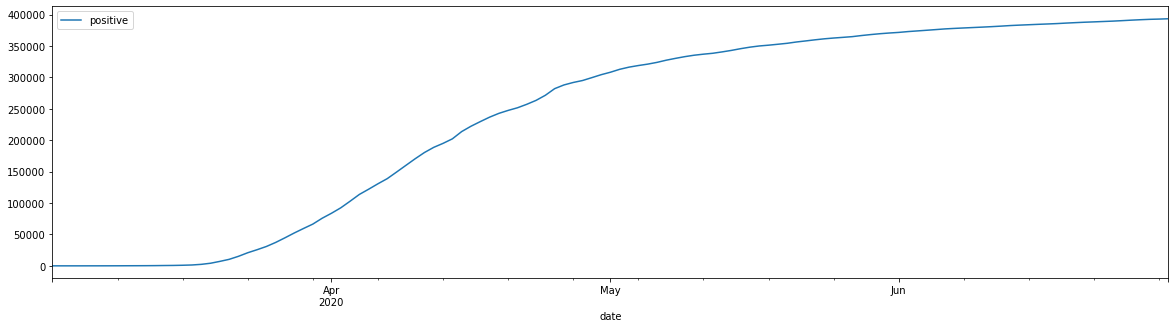

ARIMA(0, 0, 0)x(0, 0, 0, 3)3 - AIC:3354.8012732365924
ARIMA(0, 0, 0)x(0, 0, 1, 3)3 - AIC:3191.6142657989294
ARIMA(0, 0, 0)x(0, 1, 0, 3)3 - AIC:2566.076939851985
ARIMA(0, 0, 0)x(0, 1, 1, 3)3 - AIC:2434.2154460986403
ARIMA(0, 0, 0)x(1, 0, 0, 3)3 - AIC:2557.0764883697307
ARIMA(0, 0, 0)x(1, 0, 1, 3)3 - AIC:2467.7874895736554
ARIMA(0, 0, 0)x(1, 1, 0, 3)3 - AIC:2227.2404446572073
ARIMA(0, 0, 0)x(1, 1, 1, 3)3 - AIC:2208.914211271571
ARIMA(0, 0, 1)x(0, 0, 0, 3)3 - AIC:3241.698211655189
ARIMA(0, 0, 1)x(0, 0, 1, 3)3 - AIC:3142.1033103188843
ARIMA(0, 0, 1)x(0, 1, 0, 3)3 - AIC:2460.8570898622356
ARIMA(0, 0, 1)x(0, 1, 1, 3)3 - AIC:2255.9100674821425
ARIMA(0, 0, 1)x(1, 0, 0, 3)3 - AIC:3187.9586206065196
ARIMA(0, 0, 1)x(1, 0, 1, 3)3 - AIC:3136.0013088693013
ARIMA(0, 0, 1)x(1, 1, 0, 3)3 - AIC:2134.288647492535
ARIMA(0, 0, 1)x(1, 1, 1, 3)3 - AIC:2093.30200892748
ARIMA(0, 1, 0)x(0, 0, 0, 3)3 - AIC:2348.9684301958155
ARIMA(0, 1, 0)x(0, 0, 1, 3)3 - AIC:2195.960206951179
ARIMA(0, 1, 0)x(0, 1, 0, 3)3 - AIC:

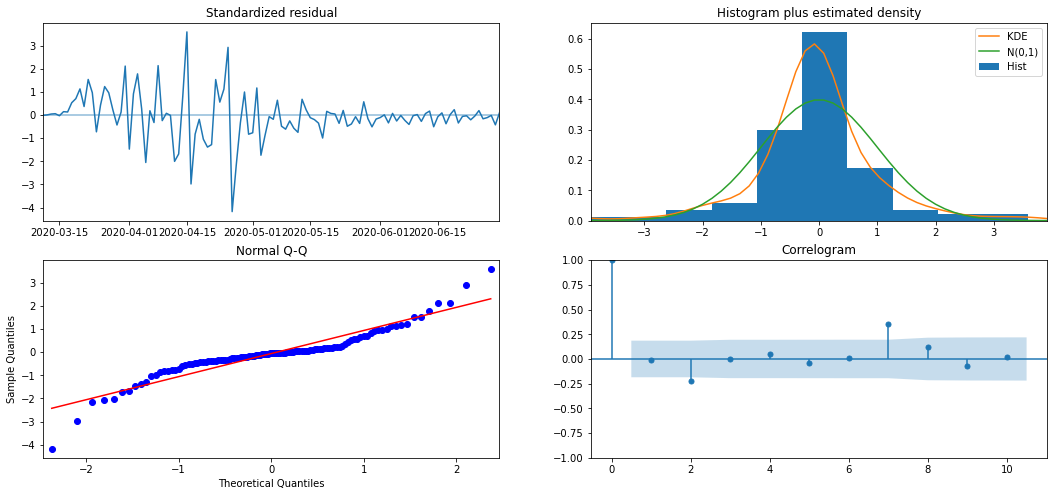

In [235]:
df_positive_cases.plot(figsize=(20,5))

plt.show()

# set each to range of 0-2
p = d = q = range(0, 2)

# generate list of 8 combination 3 digit tuples of 0s and 1
pdq = list(itertools.product(p, d, q))

# create variable m for period I want to cover
# 11 is good for full year data
m = 3
seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(df_positive_cases,order=param,seasonal_order=param_seasonal,
                                              enforce_stationarity=False,enforce_invertibility=False)
            results = model.fit()

            # place holder for m added below
            print('ARIMA{}x{}{} - AIC:{}'.format(param,param_seasonal,m,results.aic))
        except:
            continue

# we set the order and seasonal order to the results of the AIC execution
model = sm.tsa.statespace.SARIMAX(df_positive_cases,
                                order=(1, 1, 1),             # setting here AIC results
                                seasonal_order=(1, 1, 1, m), # setting here AIC results (m will always be constant)
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(18, 8))
plt.show()

## Model Forecasting for Positive Cases

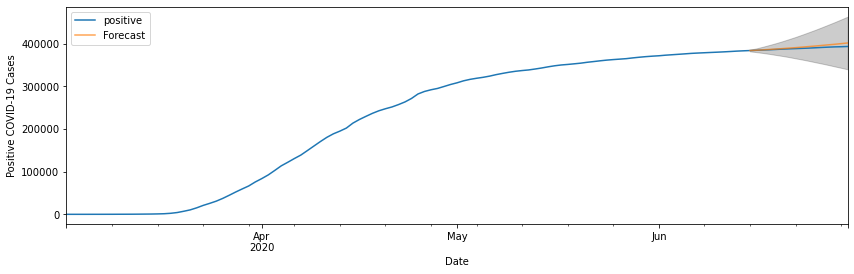

In [236]:
pred = results.get_prediction(start=pd.to_datetime('2020-06-15'), dynamic=True)
pred_ci = pred.conf_int()
ax = df_positive_cases['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Positive COVID-19 Cases')
plt.legend()
plt.show()


## Model Accuracy

Check accuracy metrices of time serise SARIMA model for postive covid cases.

In [237]:
train_sarima = df_positive_cases.iloc[:-15]
test_sarima = df_positive_cases.iloc[-15:]
start_sarima = len(train_arima)
end_sarima = len(train_sarima) + len(test_sarima)

pred_sarima_positive = results.predict(start = start_sarima, end = end_sarima)

fa_sarima_positive = forecast_accuracy(pred_sarima_positive, test_sarima['positive'])

print("{:<15} {:<10}".format('Matrices','Values'))
for k, v in fa_sarima_positive.items():
    print("{:<15} {:<10}".format(k, v))

Matrices        Values    
MAPE            0.00042583177811003625
ME              79.66383081486372
MAE             165.64493435829644
MPE             0.000204508985380015
RMSE            212.37937759826298


## SARIMA Conclusion

This model prediction shows close to actual data. SARIMA model is best fitted model for `df_positive_cases` due to very small RMSE and MAPE.

The above model, we get the equation : $y_t$ = 1.055e+06 + 0.9563$y_{t-1}$ - 0.1651$y_{t-2}$ + 0.0270$\epsilon_{t-1}$ - 0.9425$\epsilon_{t-2}$